In [778]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [779]:
import pandas as pd
import numpy as np
from scipy.stats import poisson
from scipy.stats import geom
from scipy.stats import binom
from scipy.stats import gamma
import matplotlib.pyplot as  plt
import datetime

In [780]:
df = pd.read_csv("/content/gdrive/MyDrive/Classroom/CSE 544 Prob stat/Project/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv")

In [781]:
df['submission_date'] = pd.to_datetime(df['submission_date'])

In [782]:
df = df.sort_values(by=["state",'submission_date'],ignore_index=True)

In [783]:
df = df[(df["state"]=="HI") | (df["state"]=="IA")].reset_index()

In [784]:
df

,index,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,11781,2020-01-22,HI,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Not agree,Not agree
1,11782,2020-01-23,HI,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Not agree,Not agree
2,11783,2020-01-24,HI,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Not agree,Not agree
3,11784,2020-01-25,HI,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Not agree,Not agree
4,11785,2020-01-26,HI,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Not agree,Not agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,13456,2022-05-06,IA,766593,NaN,NaN,1103,222.0,9533,NaN,NaN,0,0.0,05/07/2022 01:19:57 PM,Not agree,Not agree
1676,13457,2022-05-07,IA,766593,NaN,NaN,0,0.0,9533,NaN,NaN,0,0.0,05/09/2022 01:14:40 PM,Not agree,Not agree
1677,13458,2022-05-08,IA,766593,NaN,NaN,0,0.0,9533,NaN,NaN,0,0.0,05/09/2022 02:22:50 PM,Not agree,Not agree
1678,13459,2022-05-09,IA,767422,NaN,NaN,829,114.0,9533,NaN,NaN,0,0.0,05/10/2022 01:23:16 PM,Not agree,Not agree


# getting datatset ready for Mandatory Task A

In [785]:
df_task = df[["submission_date","tot_cases","tot_death","state"]]

In [786]:
df_task = df_task.pivot(index='submission_date', columns='state', values=['tot_cases', 'tot_death']).reset_index()
df_task = df_task.T.reset_index(drop=True).T
df_task = df_task.rename(columns={0: "submission_date", 1: "Hawaii_cases",2:"Iowa_cases",3:"Hawaii_deaths",4:"Iowa_deaths"})

In [787]:
df_task["Hawaii_cases"] = df_task["Hawaii_cases"] - df_task["Hawaii_cases"].shift(1)
df_task["Iowa_cases"] = df_task["Iowa_cases"] - df_task["Iowa_cases"].shift(1)
df_task["Hawaii_deaths"] = df_task["Hawaii_deaths"] - df_task["Hawaii_deaths"].shift(1)
df_task["Iowa_deaths"] = df_task["Iowa_deaths"] - df_task["Iowa_deaths"].shift(1)
df_task.fillna(0,inplace=True)
df_task.set_index("submission_date",inplace=True)

In [788]:
df_task

,Hawaii_cases,Iowa_cases,Hawaii_deaths,Iowa_deaths
submission_date,,,,
2020-01-22,0,0,0,0
2020-01-23,0,0,0,0
2020-01-24,0,0,0,0
2020-01-25,0,0,0,0
2020-01-26,0,0,0,0
...,...,...,...,...
2022-05-06,0,1103,0,0
2022-05-07,0,0,0,0
2022-05-08,0,0,0,0


# checking for null values and cleaning them if needed

In [789]:
Q1 = df_task.quantile(0.25)
Q3 = df_task.quantile(0.75)
IQR = Q3 - Q1

print(Q1 - 1.5 * IQR)
print(Q3 + 1.5 * IQR)

Hawaii_cases     -208.000
Iowa_cases      -1363.125
Hawaii_deaths      -3.000
Iowa_deaths       -15.000
dtype: float64
Hawaii_cases      392.000
Iowa_cases       2545.875
Hawaii_deaths       5.000
Iowa_deaths        25.000
dtype: float64


In [790]:
#Getting the rows which are outliers (detected by Tukey's rule with alpha = 1.5)
outliers = df_task[((df_task < (Q1 - 1.5 * IQR)) |(df_task > (Q3 + 1.5 * IQR))).any(axis=1)]
outliers

,Hawaii_cases,Iowa_cases,Hawaii_deaths,Iowa_deaths
submission_date,,,,
2020-08-27,263,3269,4,25
2020-08-31,179,615,7,3
2020-09-17,119,636,8,3
2020-09-18,112,1241,13,9
2020-10-04,51,620,14,6
...,...,...,...,...
2022-04-06,1138,82,3,0
2022-04-13,1300,84,8,0
2022-04-20,1666,131,17,35


In [791]:
outliers_date = outliers.reset_index().iloc[:,0].tolist()

In [792]:
df_task = df_task.reset_index()
df_final = df_task[~df_task['submission_date'].isin(outliers_date)]
df_final.set_index('submission_date', inplace = True)
# df_final = df_final.cumsum(axis = 0)
df_final.shape

(571, 4)

In [793]:
df_final

,Hawaii_cases,Iowa_cases,Hawaii_deaths,Iowa_deaths
submission_date,,,,
2020-01-22,0,0,0,0
2020-01-23,0,0,0,0
2020-01-24,0,0,0,0
2020-01-25,0,0,0,0
2020-01-26,0,0,0,0
...,...,...,...,...
2022-05-06,0,1103,0,0
2022-05-07,0,0,0,0
2022-05-08,0,0,0,0


# task 2)a

In [794]:
df_final = df_final.reset_index()

In [795]:
df_final['year'] = pd.DatetimeIndex(df_final['submission_date']).year
df_final['month'] = pd.DatetimeIndex(df_final['submission_date']).month

In [796]:
feb_data = df_final[(df_final["month"]==2) & (df_final["year"]==2021)]

In [797]:
feb_data

,submission_date,Hawaii_cases,Iowa_cases,Hawaii_deaths,Iowa_deaths,year,month
306,2021-02-01,84,567,0,5,2021,2
307,2021-02-02,62,804,0,13,2021,2
308,2021-02-07,73,506,2,0,2021,2
309,2021-02-08,30,465,0,2,2021,2
310,2021-02-11,84,853,1,22,2021,2
311,2021-02-13,77,580,0,13,2021,2
312,2021-02-14,43,401,1,0,2021,2
313,2021-02-15,31,333,0,1,2021,2
314,2021-02-18,60,714,1,15,2021,2
315,2021-02-19,44,547,2,15,2021,2


In [798]:
march_data = df_final[(df_final["month"]==3) & (df_final["year"]==2021)]

In [799]:
march_data

,submission_date,Hawaii_cases,Iowa_cases,Hawaii_deaths,Iowa_deaths,year,month
323,2021-03-01,26,318,0,1,2021,3
324,2021-03-03,17,624,2,3,2021,3
325,2021-03-05,51,505,2,13,2021,3
326,2021-03-06,119,484,1,3,2021,3
327,2021-03-07,47,316,1,6,2021,3
328,2021-03-08,41,205,0,1,2021,3
329,2021-03-09,41,557,0,15,2021,3
330,2021-03-11,54,473,0,20,2021,3
331,2021-03-12,64,495,1,9,2021,3
332,2021-03-13,156,425,1,3,2021,3


# wald test

In [800]:
def wald_test_1_sample(dist1,dist2):
  dist1_mean = np.mean(dist1)
  dist2_mean = np.mean(dist2)

  numerator = dist2_mean - dist1_mean
  denominator = np.sqrt(dist2_mean/dist2.size)
  result = numerator/denominator
  
  w = np.abs(result)
  if w>1.96:
    print("reject null hypothesis")
  else:
    print("accept null hypothesis")
  return w

def wald_test_2_sample(dist1,dist2):
  dist1_mean = np.mean(dist1)
  dist2_mean = np.mean(dist2)
  
  numer = dist2_mean-dist1_mean
  denom = np.sqrt(dist2_mean/dist2.size + dist1_mean/dist1.size)
  w = abs(numer/denom)
  if w>1.96:
    print("reject null hypothesis")
  else:
    print("accept null hypothesis")  
  return w

In [801]:
# for hawaii
hawaii_feb_cases = np.array(feb_data["Hawaii_cases"])
hawaii_march_cases = np.array(march_data["Hawaii_cases"])
Iowa_feb_cases = np.array(feb_data["Iowa_cases"])
Iowa_march_cases = np.array(march_data["Iowa_cases"])

hawaii_feb_deaths = np.array(feb_data["Hawaii_deaths"])
hawaii_march_deaths = np.array(march_data["Hawaii_deaths"])
Iowa_feb_deaths = np.array(feb_data["Iowa_deaths"])
Iowa_march_deaths = np.array(march_data["Iowa_deaths"])

# cases
print(wald_test_1_sample(hawaii_feb_cases,hawaii_march_cases))
print(wald_test_1_sample(Iowa_feb_cases,Iowa_march_cases))
#deaths
print(wald_test_1_sample(hawaii_feb_deaths,hawaii_march_deaths))
print(wald_test_1_sample(Iowa_feb_deaths,Iowa_march_deaths))


reject null hypothesis
10.722503138986319
reject null hypothesis
23.70761970984968
accept null hypothesis
1.1681075300867827
reject null hypothesis
5.498717658953222


In [802]:
# cases
print(wald_test_2_sample(hawaii_feb_cases,hawaii_march_cases))
print(wald_test_2_sample(Iowa_feb_cases,Iowa_march_cases))
#deaths
print(wald_test_2_sample(hawaii_feb_deaths,hawaii_march_deaths))
print(wald_test_2_sample(Iowa_feb_deaths,Iowa_march_deaths))

reject null hypothesis
7.119049455593124
reject null hypothesis
13.708691681336964
accept null hypothesis
0.667011318708645
reject null hypothesis
3.020212097633475


# z test

In [803]:
def z_test(dist1, dist2, full):
  dist1_mean = np.mean(dist1)
  dist2_mean = np.mean(dist2)
  
  numer = dist2_mean - dist1_mean
  denom = np.sqrt(np.var(full)/full.size)
  
  z = abs(numer/denom)
  if z>1.960:
    print("reject null hypothesis")
  else:
    print("accept null hypothesis")
  return z

In [804]:
print(z_test(hawaii_feb_cases,hawaii_march_cases,np.array(df_final["Hawaii_cases"])))
print(z_test(Iowa_feb_cases,Iowa_march_cases,np.array(df_final["Iowa_cases"])))

#deaths

print(z_test(hawaii_feb_deaths,hawaii_march_deaths,np.array(df_final["Hawaii_deaths"])))
print(z_test(Iowa_feb_deaths,Iowa_march_deaths,np.array(df_final["Iowa_deaths"])))

reject null hypothesis
5.673777858813078
reject null hypothesis
4.729779904419943
reject null hypothesis
3.9252309873283546
reject null hypothesis
11.34859953130403


# t-test

In [805]:
def t_test_1sample(dist1, dist2, threshold):
  dist1_mean = np.mean(dist1)
  dist2_mean = np.mean(dist2)
  
  numer = dist2_mean - dist1_mean
  denom = np.sqrt(np.var(dist2)/dist2.size)
  
  t = abs(numer/denom)
  if t>threshold:
    print("reject null hypothesis")
  else:
    print("accept null hypothesis")
  return t

In [806]:
def t_test_2sample_unpaired(dist1, dist2,threshold):
  dist1_mean = np.mean(dist1)
  dist2_mean = np.mean(dist2)
  
  numer = dist2_mean - dist1_mean
  denom = np.sqrt(np.var(dist2)/dist2.size + np.var(dist1)/dist1.size)
  
  t = abs(numer/denom)
  if t>threshold:
    print("reject null hypothesis")
  else:
    print("accept null hypothesis")
  return t
    

n = 28 for march in out dataset after outlier cleaning
t(n-1,alpha/2) = 2.052

In [807]:
threshold = 2.052

In [808]:
# cases
print("Hawaii feb cases vs Hawaii March Cases")
print(t_test_1sample(hawaii_feb_cases,hawaii_march_cases,threshold))
print()
print("Iowa feb cases vs Iowa March Cases")
print(t_test_1sample(Iowa_feb_cases,Iowa_march_cases,threshold))
print()
#deaths
print("Hawaii feb deaths vs Hawaii March deaths")
print(t_test_1sample(hawaii_feb_deaths,hawaii_march_deaths,threshold))
print()
print("Iowa feb deaths vs Iowa March deaths")
print(t_test_1sample(Iowa_feb_deaths,Iowa_march_deaths,threshold))

Hawaii feb cases vs Hawaii March Cases
reject null hypothesis
2.2868273523121077

Iowa feb cases vs Iowa March Cases
reject null hypothesis
3.409790776514401

Hawaii feb deaths vs Hawaii March deaths
accept null hypothesis
1.1612159800881006

Iowa feb deaths vs Iowa March deaths
reject null hypothesis
2.442096164544151


In [809]:
# cases
print("Hawaii feb cases vs Hawaii March Cases")
print(t_test_2sample_unpaired(hawaii_feb_cases,hawaii_march_cases,threshold))
print()
print("Iowa feb cases vs Iowa March Cases")
print(t_test_2sample_unpaired(Iowa_feb_cases,Iowa_march_cases,threshold))
print()
#deaths
print("Hawaii feb deaths vs Hawaii March deaths")
print(t_test_2sample_unpaired(hawaii_feb_deaths,hawaii_march_deaths,threshold))
print()
print("Iowa feb deaths vs Iowa March deaths")
print(t_test_2sample_unpaired(Iowa_feb_deaths,Iowa_march_deaths,threshold))

Hawaii feb cases vs Hawaii March Cases
accept null hypothesis
1.8078276860478544

Iowa feb cases vs Iowa March Cases
accept null hypothesis
2.019654741334597

Hawaii feb deaths vs Hawaii March deaths
accept null hypothesis
0.605871042839492

Iowa feb deaths vs Iowa March deaths
accept null hypothesis
1.1234241936106828


# task 2) b

In [810]:
def MME_Poisson(X):
    return np.mean(X)

def CDF_Poisson(lambda_, x):
    return poisson.cdf(x, lambda_)

def MME_Geometric(X):
    return 1/np.mean(X)

def CDF_Geometric(p,x):
    return geom.cdf(x, p)

def MME_Binomial(X):
    mean = np.mean(X)
    var = np.var(X)
    p_hat = 1 - (var/mean)
    n_hat = mean/p_hat    
    return p_hat,n_hat

def CDF_Binomial(params,x):
    return binom.cdf(x, params[0], params[1])


In [811]:
def get_eCDF(X):
    n = len(X)
    Sorted_array = sorted(X)
    delta = .1
    X = []
    Y = [0]
    for i in range(0,n):
        X = X + [Sorted_array[i]]
        Y = Y + [Y[len(Y)-1]+(1/n)]
    Y = Y + [1]
        
    return X,Y


def KS_Test_1_sample(X1,Y1, CDF_function, parameter):
    tot_max = -1
        
    Matrix = np.zeros((len(X1),4))
    for i in range(len(Matrix)):
        Matrix[i,0] = Y1[i]
        Matrix[i,1] = Y1[i+1]
        F_x = CDF_function(parameter, X1[i])
        Matrix[i,2] = abs(Matrix[i,0] - F_x)
        Matrix[i,3] = abs(Matrix[i,1] - F_x)
        cmax = max(Matrix[i,2], Matrix[i,3])
        if cmax > tot_max:
            tot_max = cmax
    if tot_max>0.05:
      print("rejecting null hypothesis")
    else:
      print("accepting null hypothesis")
    return tot_max
    

def KS_test_2_sample(X1,Y1, X2,Y2):
  # initializing the needed 6 columns for KS testing
    Matrix = np.zeros((len(X1),6))
    tot_max = -1
    for i in range(len(Matrix)):
        Matrix[i,0] = Y1[i]
        Matrix[i,1] = Y1[i+1]
        index1 = [idx for idx, val in enumerate(X2) if val >= X1[i]]
        index2 = [idx for idx, val in enumerate(X2) if val < X1[i]]
        if index1 == []:
            Matrix[i,3] = 1
        else :    
            Matrix[i,3] = Y2[index1[0]]
        if index2 == []:
            Matrix[i,2] = 0
        else:
            Matrix[i,2] = Y2[index2[-1]]
        # cdf - left ecdf        
        Matrix[i,4] = abs( Matrix[i,0] - Matrix[i,2])
        #cdf - right ecdf
        Matrix[i,5] = abs(Matrix[i,1] - Matrix[i,3])
        # getting maximum value
        cmax = max(Matrix[i,4], Matrix[i,5])
        if cmax > tot_max:
            tot_max = cmax
            x1_max = X1[i]
            y1_max = Matrix[i,0]
            y2_max = Matrix[i,2]
    if tot_max>0.05:
      print("Reject Null Hypothesis")
    else:
      print("Accept Null Hypothesis")
    
    return tot_max

In [812]:
df_final

,submission_date,Hawaii_cases,Iowa_cases,Hawaii_deaths,Iowa_deaths,year,month
0,2020-01-22,0,0,0,0,2020,1
1,2020-01-23,0,0,0,0,2020,1
2,2020-01-24,0,0,0,0,2020,1
3,2020-01-25,0,0,0,0,2020,1
4,2020-01-26,0,0,0,0,2020,1
...,...,...,...,...,...,...,...
566,2022-05-06,0,1103,0,0,2022,5
567,2022-05-07,0,0,0,0,2022,5
568,2022-05-08,0,0,0,0,2022,5
569,2022-05-09,0,829,0,0,2022,5


In [813]:
df_task2_b = df_final[(df_final["submission_date"]>="2021-10-01") & (df_final["submission_date"]<="2021-12-31")]

# ks-1 sample between cases 

In [814]:
first_state = 'Hawaii_cases'
second_state = 'Iowa_cases'
second_state_data = df_task2_b[second_state]
test_X, test_Y = get_eCDF(second_state_data)
ks_threshold = 0.05

In [815]:
print('Poisson Distribution')
print("Null Hypothesis is that there is equality of distributions between Hawaii cases and Iowa cases")
CDF_dist = CDF_Poisson
parameter = MME_Poisson(df_task2_b[first_state])
print('Poisson parameter: ', parameter)
KS_value = KS_Test_1_sample(test_X, test_Y, CDF_dist, parameter)
print('KS statistic : ', KS_value)
print()
print("Geometric Distribution")
print("Null Hypothesis is that there is equality of distributions between Hawaii cases and Iowa cases")
p = MME_Geometric(df_task2_b[first_state])
CDF_dist = CDF_Geometric
print('Geometric parameter : ', p)
KS_value = KS_Test_1_sample(test_X, test_Y, CDF_dist, p )
print('KS statistic : ', KS_value)
print()
print('Binomial Distribution')
print("Null Hypothesis is that there is equality of distributions between Hawaii cases and Iowa cases")
n,p = MME_Binomial(df_task2_b[first_state])
CDF_dist = CDF_Binomial
print('Binomial parameters(n,p) : ', n,p)
KS_value = KS_Test_1_sample(test_X, test_Y, CDF_dist, [n,p] )
print('KS statistic : ', KS_value)


Poisson Distribution
Null Hypothesis is that there is equality of distributions between Hawaii cases and Iowa cases
Poisson parameter:  134.36111111111111
rejecting null hypothesis
KS statistic :  0.5277777777777777

Geometric Distribution
Null Hypothesis is that there is equality of distributions between Hawaii cases and Iowa cases
Geometric parameter :  0.007442629729170974
rejecting null hypothesis
KS statistic :  0.4722222222222224

Binomial Distribution
Null Hypothesis is that there is equality of distributions between Hawaii cases and Iowa cases
Binomial parameters(n,p) :  -34.92026164059449 -3.847654765418983
rejecting null hypothesis
KS statistic :  1.0


# ks- 1 sample between deaths

In [816]:
first_state = 'Hawaii_deaths'
second_state = 'Iowa_deaths'
second_state_data = df_task2_b[second_state]
test_X, test_Y = get_eCDF(second_state_data)

In [817]:
print('Poisson Distribution')
print("Null Hypothesis is that there is equality of distributions between Hawaii deaths and Iowa deaths")
CDF_dist = CDF_Poisson
parameter = MME_Poisson(df_task2_b[first_state])
print(' Poisson parameter: ', parameter)
KS_value = KS_Test_1_sample(test_X, test_Y, CDF_dist, parameter)
print(' KS statistic : ', KS_value)
print()
print('Geometric Distribution')
print("Null Hypothesis is that there is equality of distributions between Hawaii deaths and Iowa deaths")
p = MME_Geometric(df_task2_b[first_state])
CDF_dist = CDF_Geometric
print(' Geometric parameter : ', p)
KS_value = KS_Test_1_sample(test_X, test_Y, CDF_dist, p )
print(' KS statistic : ', KS_value)
print()
print('Binomial Distribution')
print("Null Hypothesis is that there is equality of distributions between Hawaii deaths and Iowa deaths")
n,p = MME_Binomial(df_task2_b[first_state])
CDF_dist = CDF_Binomial
print(' Binomial parameters(n,p) : ', n,p)
KS_value = KS_Test_1_sample(test_X, test_Y, CDF_dist, [n,p] )
print(' KS statistic : ', KS_value)


Poisson Distribution
Null Hypothesis is that there is equality of distributions between Hawaii deaths and Iowa deaths
 Poisson parameter:  2.4722222222222223
rejecting null hypothesis
 KS statistic :  0.9156028986548875

Geometric Distribution
Null Hypothesis is that there is equality of distributions between Hawaii deaths and Iowa deaths
 Geometric parameter :  0.4044943820224719
rejecting null hypothesis
 KS statistic :  1.0000000000000002

Binomial Distribution
Null Hypothesis is that there is equality of distributions between Hawaii deaths and Iowa deaths
 Binomial parameters(n,p) :  -0.3367665418227215 -7.341056533827621
rejecting null hypothesis
 KS statistic :  1.0


# ks- 2 sample between cases

In [818]:
first_state = 'Hawaii_cases'
second_state = 'Iowa_cases'
first_state_data = df_task2_b[first_state]
second_state_data = df_task2_b[second_state]

In [819]:
print("Null Hypothesis is that there is equality of distributions between Hawaii cases and Iowa cases")
X1, Y1 = get_eCDF(first_state_data)
X2, Y2 = get_eCDF(second_state_data)
KS_value = KS_test_2_sample(X1,Y1, X2,Y2)
print('KS statistic : ', KS_value)


Null Hypothesis is that there is equality of distributions between Hawaii cases and Iowa cases
Reject Null Hypothesis
KS statistic :  0.5000000000000002


# ks-2 sample between deaths

In [820]:
first_state = 'Hawaii_deaths'
second_state = 'Iowa_deaths'
first_state_data = df_task2_b[first_state]
second_state_data = df_task2_b[second_state]

In [821]:
print("Null Hypothesis is that there is equality of distributions between Hawaii deaths and Iowa deaths")
X1,Y1 = get_eCDF(first_state_data)
X2,Y2 = get_eCDF(second_state_data)
KS_value = KS_test_2_sample(X1,Y1,X2,Y2)
print('KS statistic : ', KS_value)

Null Hypothesis is that there is equality of distributions between Hawaii deaths and Iowa deaths
Reject Null Hypothesis
KS statistic :  0.7222222222222225


# permutation test for cases

In [822]:
def get_Ti(n_perm, data, n1):
    T = []
    for i in range(n_perm):
        permute = np.random.permutation(len(data))
        D1 = data[permute[:n1]]
        D2 = data[permute[n1:]]
        T.append(abs(np.mean(D1) - np.mean(D2)))
    
    return np.array(T)

def get_p_value(T,T_obs):
    count = np.sum(T > T_obs)
    p_val = count/len(T)
    return p_val

In [823]:
first_state = 'Hawaii_cases'
second_state = 'Iowa_cases'
first_state_data = df_task2_b[first_state]
second_state_data = df_task2_b[second_state]

In [824]:
print("Null Hypothesis is that both Hawaii_cases and Iowa_cases have same distribution")
T_obs = np.abs(np.mean(first_state_data) - np.mean(second_state_data))
print(" T_observed is : " ,T_obs)

total_data = np.concatenate((np.array(first_state_data) , np.array(second_state_data)))

T_i = get_Ti(1000, total_data, len(first_state_data))

p = get_p_value(T_i, T_obs)

print(' p statistic : ', p)
if p<0.05:
  print("reject the null hypothesis")
else:
  print("accept the null hypothesis")

Null Hypothesis is that both Hawaii_cases and Iowa_cases have same distribution
 T_observed is :  530.5555555555555
 p statistic :  0.0
reject the null hypothesis


# permutation Test for deaths

In [825]:
first_state = 'Hawaii_deaths'
second_state = 'Iowa_deaths'
first_state_data = df_task2_b[first_state]
second_state_data = df_task2_b[second_state]


In [826]:
print("Null Hypothesis is that both Hawaii_deaths and Iowa_deaths have same distribution")
T_obs = np.abs(np.mean(first_state_data) - np.mean(second_state_data))
print(" T_observed is : " ,T_obs)
total_data = np.concatenate((np.array(first_state_data) , np.array(second_state_data)))
T_i = get_Ti(1000, total_data, len(first_state_data))
p = get_p_value(T_i, T_obs)
print(' p statistic : ', p)
if p<0.05:
  print("reject the null hypothesis")
else:
  print("accept the null hypothesis")

Null Hypothesis is that both Hawaii_deaths and Iowa_deaths have same distribution
 T_observed is :  2.4722222222222223
 p statistic :  0.0
reject the null hypothesis


# part c

In [827]:
def MME_Poisson(X):
    return np.mean(X)

def get_estimates(exp_a, lambda_a, exp_b, lambda_b):
    return exp_a + exp_b, lambda_a + lambda_b

def plot_posterior(matrix):
    for estimate in matrix:
        alpha, beta = estimate[0], estimate[1]
        x = np.linspace(gamma.ppf(0.01, alpha),gamma.ppf(0.99, alpha), 100)
        MAP = (alpha-1)/beta
        plt.plot(x, gamma.pdf(x, alpha), label = 'MAP: %.4f ' %(MAP))
    plt.xlabel("x")
    plt.ylabel("PDF")
    plt.legend(loc="upper right")
    plt.title('Posterior')
    plt.show()

In [828]:
df_final

,submission_date,Hawaii_cases,Iowa_cases,Hawaii_deaths,Iowa_deaths,year,month
0,2020-01-22,0,0,0,0,2020,1
1,2020-01-23,0,0,0,0,2020,1
2,2020-01-24,0,0,0,0,2020,1
3,2020-01-25,0,0,0,0,2020,1
4,2020-01-26,0,0,0,0,2020,1
...,...,...,...,...,...,...,...
566,2022-05-06,0,1103,0,0,2022,5
567,2022-05-07,0,0,0,0,2022,5
568,2022-05-08,0,0,0,0,2022,5
569,2022-05-09,0,829,0,0,2022,5


In [829]:
june_start_date, june_end_date = datetime.datetime(2020, 6, 1) , datetime.datetime(2020, 6, 28) # 28 days only
posterior_week_start_date, posterior_week_end_date = datetime.datetime(2020, 6, 29) , datetime.datetime(2020, 7, 5)

june_data_for_28_days = df_final.loc[(df_final['submission_date'] >= june_start_date) & (df_final['submission_date'] <= june_end_date)] 
posterior_week_data = df_final.loc[(df_final['submission_date'] >= posterior_week_start_date) & (df_final['submission_date'] <= posterior_week_end_date)] 

In [830]:
handle_state_1 = 'Hawaii_deaths'
handle_state_2 = 'Iowa_deaths'
handle_state_3 = "Hawaii_cases"
handle_state_4 = "Iowa_cases"

june_data_for_28_days = june_data_for_28_days[handle_state_1] + june_data_for_28_days[handle_state_2] + june_data_for_28_days[handle_state_3] + june_data_for_28_days[handle_state_4]
posterior_week_data_ = posterior_week_data[handle_state_1] + posterior_week_data[handle_state_2] + posterior_week_data[handle_state_3] + posterior_week_data[handle_state_4]

 MME of poisson distributed data  333.85714285714283
 Prior beta value  0.0029952931108258455


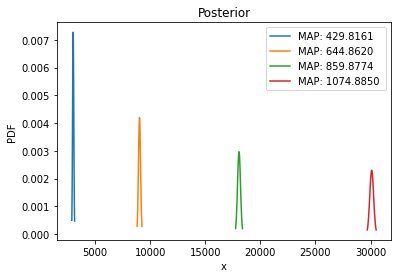

In [831]:
lambda_ = MME_Poisson(june_data_for_28_days)
print(' MME of poisson distributed data ', lambda_)
exp_lambda = 1/lambda_ 
print(' Prior beta value ', exp_lambda)
likelihood_exp_power,likelihood_lambda_power,prior_exp_power,prior_lambda_power = len(posterior_week_data_),np.sum(posterior_week_data_),exp_lambda,0

matrix = []
i = 0
while i<4:
    prior_exp_power, prior_lambda_power = get_estimates(likelihood_exp_power, likelihood_lambda_power, prior_exp_power, prior_lambda_power)
    matrix.append([prior_lambda_power + 1,prior_exp_power])

    # increasing the week by adding 7 days
    posterior_week_start_date += datetime.timedelta(days=7)
    posterior_week_end_date += datetime.timedelta(days=7)
    posterior_week_data_ = df_final.loc[(df_final['submission_date'] >= posterior_week_start_date) & (df_final['submission_date'] <= posterior_week_end_date)]
    posterior_week_data_ = posterior_week_data[handle_state_1] + posterior_week_data[handle_state_2] + posterior_week_data[handle_state_3] + posterior_week_data[handle_state_4]
    
    likelihood_exp_power = len(posterior_week_data_)
    likelihood_lambda_power+=np.sum(posterior_week_data_)
    i+=1
plot_posterior(matrix)

In [832]:
df = pd.read_csv("/content/gdrive/MyDrive/Classroom/CSE 544 Prob stat/Project/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv")

In [833]:
df['Date'] = pd.to_datetime(df['Date'])

In [834]:
df = df[(df["Location"]=="HI") | (df["Location"]=="IA")].reset_index()

In [835]:
df = df.sort_values(by=['Location',"Date"],ignore_index=True)

In [836]:
df_final = df[["Date","Location","Administered"]]

In [837]:
df_final = df_final.pivot(index='Date', columns='Location', values=['Administered']).reset_index()
df_final = df_final.T.reset_index(drop=True).T
df_final = df_final.rename(columns={0: "Date", 1: "HI",2:"IA"})

In [838]:
df_final["HI"] = df_final["HI"] - df_final["HI"].shift(1)
df_final["IA"] = df_final["IA"] - df_final["IA"].shift(1)

df_final.fillna(0,inplace=True)
df_final.set_index("Date",inplace=True)

In [839]:
Q1 = df_final.quantile(0.25)
Q3 = df_final.quantile(0.75)
IQR = Q3 - Q1

print(Q1 - 1.5 * IQR)
print(Q3 + 1.5 * IQR)

HI    -6156.5
IA   -15676.5
dtype: float64
HI    13919.5
IA    30647.5
dtype: float64


In [840]:
outliers = df_final[((df_final < (Q1 - 1.5 * IQR)) |(df_final > (Q3 + 1.5 * IQR))).any(axis=1)]


In [841]:
outliers_date = outliers.reset_index().iloc[:,0].tolist()

In [842]:
df_final = df_final.reset_index()
df_final_clean = df_final[~df_final['Date'].isin(outliers_date)]
df_final.set_index('Date', inplace = True)
# df_final_clean = df_final.cumsum(axis = 0)
df_final_clean.shape

(457, 3)

In [843]:
df_final_clean

,Date,HI,IA
0,2020-12-14,0,0
1,2020-12-15,5,0
2,2020-12-16,325,399
3,2020-12-17,1523,1294
4,2020-12-18,1143,0
...,...,...,...
508,2022-05-06,2626,4581
509,2022-05-07,2243,4149
510,2022-05-08,58,12
511,2022-05-09,1,0


# Task D

In [844]:
may_first_three_weeks = df_final_clean[(df_final_clean["Date"]>=datetime.datetime(2021, 5, 1)) & (df_final_clean["Date"]<=datetime.datetime(2021, 5, 21))]
may_last_week = df_final_clean[(df_final_clean["Date"]>=datetime.datetime(2021, 5,22)) & (df_final_clean["Date"]<=datetime.datetime(2021, 5, 28))]

In [845]:
class LinearRegression:
    def __init__(self):
        self.beta = []
    
    def fit(self, X, Y):
        if (len(X.shape)==1):
            X = np.reshape(X, (-1,1))
        X = np.concatenate((X,np.ones(shape=X.shape[0]).reshape(-1,1)), 1)
        self.beta = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, Y))
        print(self.beta)
        return self.beta
            
    def predict(self, data):
        prediction = self.beta[0]
        beta_values = self.beta[1:]
        for i in range(len(data)):
            prediction += data[i]*beta_values[i]
        return prediction

In [846]:
class AutoRegression:
    def __init__(self, p):
        self.p = p
        self.LR = LinearRegression()
    
    def fit(self, train):
        self.data = train
        return
    
    def train_lr(self,p,curr_len):
        X = []
        Y = []
        for i in range(curr_len):
            if(i+p < curr_len):
                X.append([1])
                X[i] = X[i]+list(self.data[i:i+p])
                Y.append(self.data[i+p])
            else:
                break
        beta=np.matmul(np.linalg.inv(np.matmul(np.transpose(X),X)),np.matmul(np.transpose(X),Y))
        return beta
        
    def predict(self, test):
        self.data = np.hstack([self.data, test])
        p = self.p
        t = self.data.shape[0] - test.shape[0]
        error = np.zeros(test.shape[0])
        predictions = np.zeros(test.shape[0])
        for i in range(t,t+test.shape[0]):
            testx = [1]
            testx = np.hstack([[1], self.data[i-p:i]])
            beta = self.train_lr(p,i)
            predictions[i-t] = np.matmul(testx,beta)
            error[i-t] = (abs(predictions[i-t]-self.data[i])/self.data[i])*100
            print("Test prediction: " + "{:5.2f}".format(predictions[i-t]) + " Actual: " + str(test[i-t]))
        mse_errors = np.zeros(len(test))
        mape_errors = np.zeros(len(test))
        for t in range(len(test)):
            y_t = test[t]
            y_t_hat = predictions[t]
            residual = y_t_hat - y_t
            mape_errors[t] = (abs(residual)/y_t)*100
            mse_errors[t] = residual**2
        print("MAPE:" + "{:5.2f}".format(np.mean(mape_errors)))
        print("MSE:" + "{:5.2f}".format(np.mean(mse_errors)))      


In [847]:
class EWMA:
    def __init__(self, alpha):
        self.alpha = alpha
    def predict(self,data,test):
        y_t_hat = data[0]
        for i in range(len(data)):
            y_t = data[i]
            y_t_hat = self.alpha*y_t + (1-self.alpha)*y_t_hat
        
        mse_errors = []
        mape_errors = []
        predictions = np.zeros(len(test))
        #predicting values
        for i in np.arange(len(test)):
            y_t = test[i]
            print("Test Prediction: " + "{:5.3f}".format(y_t_hat) + ", Actual: " + "{:5.3f}".format(y_t))
            if y_t!=0:
                mape_errors.append(abs(y_t_hat-y_t)*100/y_t)
                mse_errors.append((y_t_hat-y_t)**2)
            predictions[i] = y_t_hat = self.alpha*y_t + (1-self.alpha)* y_t_hat
        print()
        print("MAPE:" + "{:5.2f}".format(np.mean(mape_errors)))
        print("MSE:" + "{:5.2f}".format(np.mean(mse_errors)))

# for Hawaii

In [848]:
print("Hawaii AR(3)")
train = np.array(may_first_three_weeks["HI"])
test = np.array(may_last_week["HI"])
ar = AutoRegression(3)
ar.fit(train)
ar.predict(test)

Hawaii AR(3)
Test prediction: 5000.97 Actual: 11407
Test prediction: 4716.40 Actual: 1347
Test prediction: 3653.24 Actual: 13812
Test prediction: 6473.49 Actual: 8307
Test prediction: 5062.34 Actual: 4925
Test prediction: 7293.25 Actual: 435
Test prediction: 7773.53 Actual: 5050
MAPE:290.75
MSE:30489191.75


In [849]:
print("Hawaii AR(5)")
train = np.array(may_first_three_weeks["HI"])
test = np.array(may_last_week["HI"])
ar = AutoRegression(5)
ar.fit(train)
ar.predict(test)

Hawaii AR(5)
Test prediction: 10949.93 Actual: 11407
Test prediction: 3662.39 Actual: 1347
Test prediction: 3693.18 Actual: 13812
Test prediction: 11831.31 Actual: 8307
Test prediction: 9928.86 Actual: 4925
Test prediction: 9146.18 Actual: 435
Test prediction: 12115.98 Actual: 5050
MAPE:362.24
MSE:38747520.59


In [850]:
print("Hawaii EWMA(0.5)")
train = np.array(may_first_three_weeks["HI"])
test = np.array(may_last_week["HI"])
ewma = EWMA(0.5)
ewma.predict(train,test)

Hawaii EWMA(0.5)
Test Prediction: 9608.367, Actual: 11407.000
Test Prediction: 10507.683, Actual: 1347.000
Test Prediction: 5927.342, Actual: 13812.000
Test Prediction: 9869.671, Actual: 8307.000
Test Prediction: 9088.335, Actual: 4925.000
Test Prediction: 7006.668, Actual: 435.000
Test Prediction: 3720.834, Actual: 5050.000

MAPE:341.90
MSE:30578548.38


In [851]:
print("Hawaii EWMA(0.8)")
train = np.array(may_first_three_weeks["HI"])
test = np.array(may_last_week["HI"])
ewma = EWMA(0.8)
ewma.predict(train,test)

Hawaii EWMA(0.8)
Test Prediction: 12094.117, Actual: 11407.000
Test Prediction: 11544.423, Actual: 1347.000
Test Prediction: 3386.485, Actual: 13812.000
Test Prediction: 11726.897, Actual: 8307.000
Test Prediction: 8990.979, Actual: 4925.000
Test Prediction: 5738.196, Actual: 435.000
Test Prediction: 1495.639, Actual: 5050.000

MAPE:321.68
MSE:40305170.73


# for Iowa

In [852]:
print("Iowa AR(3)")
train = np.array(may_first_three_weeks["IA"])
test = np.array(may_last_week["IA"])
ar = AutoRegression(3)
ar.fit(train)
ar.predict(test)

Iowa AR(3)
Test prediction: 12866.43 Actual: 18700
Test prediction: 20073.12 Actual: 16830
Test prediction: 14911.49 Actual: 10436
Test prediction: 14283.13 Actual: 5291
Test prediction: 14060.21 Actual: 8826
Test prediction: 17123.33 Actual: 11406
Test prediction: 17806.13 Actual: 12398
MAPE:59.48
MSE:33538503.47


In [853]:
print("Iowa AR(5)")
train = np.array(may_first_three_weeks["IA"])
test = np.array(may_last_week["IA"])
ar = AutoRegression(5)
ar.fit(train)
ar.predict(test)

Iowa AR(5)
Test prediction: 2162.07 Actual: 18700
Test prediction: 16989.90 Actual: 16830
Test prediction: 19735.88 Actual: 10436
Test prediction: 12506.21 Actual: 5291
Test prediction: 12046.12 Actual: 8826
Test prediction: 14708.51 Actual: 11406
Test prediction: 17280.34 Actual: 12398
MAPE:59.96
MSE:65312647.60


In [854]:
print("Iowa EWMA(0.5)")
train = np.array(may_first_three_weeks["IA"])
test = np.array(may_last_week["IA"])
ewma = EWMA(0.5)
ewma.predict(train,test)

Iowa EWMA(0.5)
Test Prediction: 16214.469, Actual: 18700.000
Test Prediction: 17457.234, Actual: 16830.000
Test Prediction: 17143.617, Actual: 10436.000
Test Prediction: 13789.809, Actual: 5291.000
Test Prediction: 9540.404, Actual: 8826.000
Test Prediction: 9183.202, Actual: 11406.000
Test Prediction: 10294.601, Actual: 12398.000

MAPE:40.92
MSE:19095522.14


In [855]:
print("Iowa EWMA(0.8)")
train = np.array(may_first_three_weeks["IA"])
test = np.array(may_last_week["IA"])
ewma = EWMA(0.8)
ewma.predict(train,test)

Iowa EWMA(0.8)
Test Prediction: 17643.849, Actual: 18700.000
Test Prediction: 18488.770, Actual: 16830.000
Test Prediction: 17161.754, Actual: 10436.000
Test Prediction: 11781.151, Actual: 5291.000
Test Prediction: 6589.030, Actual: 8826.000
Test Prediction: 8378.606, Actual: 11406.000
Test Prediction: 10800.521, Actual: 12398.000

MAPE:38.20
MSE:15420840.32


# Task E

In [856]:
def paired_t_test(dist1,dist2):
  d_bar = np.subtract(dist1,dist2)
  sd = np.sqrt(np.var(d_bar))
  numerator = np.mean(d_bar)
  denominator = sd/np.sqrt(len(dist1))
  return abs(numerator/denominator)


In [857]:
df_final_clean['year'] = df_final_clean['Date'].dt.year
df_final_clean['month'] = df_final_clean['Date'].dt.month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [858]:
df_sept = df_final_clean[(df_final_clean["month"]==9) & (df_final_clean["year"]==2021)]

In [859]:
df_nov = df_final_clean[(df_final_clean["month"]==11) & (df_final_clean["year"]==2021)]

In [860]:
df_sept

,Date,HI,IA,year,month
261,2021-09-01,3904,5372,2021,9
262,2021-09-02,1142,4367,2021,9
263,2021-09-03,6688,7654,2021,9
264,2021-09-04,5529,6196,2021,9
265,2021-09-05,3843,41,2021,9
266,2021-09-06,1847,17,2021,9
267,2021-09-07,949,39,2021,9
268,2021-09-08,1940,15693,2021,9
269,2021-09-09,4233,4034,2021,9
270,2021-09-10,4829,5911,2021,9


In [861]:
df_HI_sept = np.array(df_sept["HI"])
df_HI_nov = np.array(df_nov["HI"])
df_IA_sept = np.array(df_sept["IA"])
df_IA_nov = np.array(df_nov["IA"])

In [862]:
print("null hypothesis is that means of the #vaccines administered between the two states for the months of September 2021 and November 2021")
t_sept = paired_t_test(df_HI_sept,df_IA_sept)
print("t value for september is: "+ str(t_sept))
if t_sept>2.045:
  print("reject null hypothesis")
else:
  print("accept null hypothesis")
t_nov = paired_t_test(df_HI_nov,df_IA_nov)
print("t value for novermber is: "+ str(t_nov))
if t_nov>2.069:
  print("reject null hypothesis")
else:
  print("accept null hypothesis")

null hypothesis is that means of the #vaccines administered between the two states for the months of September 2021 and November 2021
t value for september is: 2.2113837108049004
reject null hypothesis
t value for novermber is: 2.697930261674824
reject null hypothesis
